## 1. Data Analysis and PreProcessing

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/SPY.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547979,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729698,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784185,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056759,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165777,531500


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7381 entries, 1993-01-29 to 2022-05-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7381 non-null   float64
 1   High       7381 non-null   float64
 2   Low        7381 non-null   float64
 3   Close      7381 non-null   float64
 4   Adj Close  7381 non-null   float64
 5   Volume     7381 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 403.6 KB


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7.381000e+03
mean,157.129240,158.057594,156.089031,157.124624,131.101209,8.457678e+07
std,92.432355,92.878856,91.913232,92.428001,98.628984,9.468714e+07
min,43.343750,43.531250,42.812500,43.406250,25.239080,5.200000e+03
25%,102.375000,103.239998,101.620003,102.489998,71.187546,8.569500e+06
50%,129.399994,130.187500,128.529999,129.360001,93.892067,6.014660e+07
75%,199.270004,200.270004,198.429993,199.380005,174.222977,1.194654e+08
max,479.220001,479.980011,476.059998,477.709991,476.230530,8.710263e+08


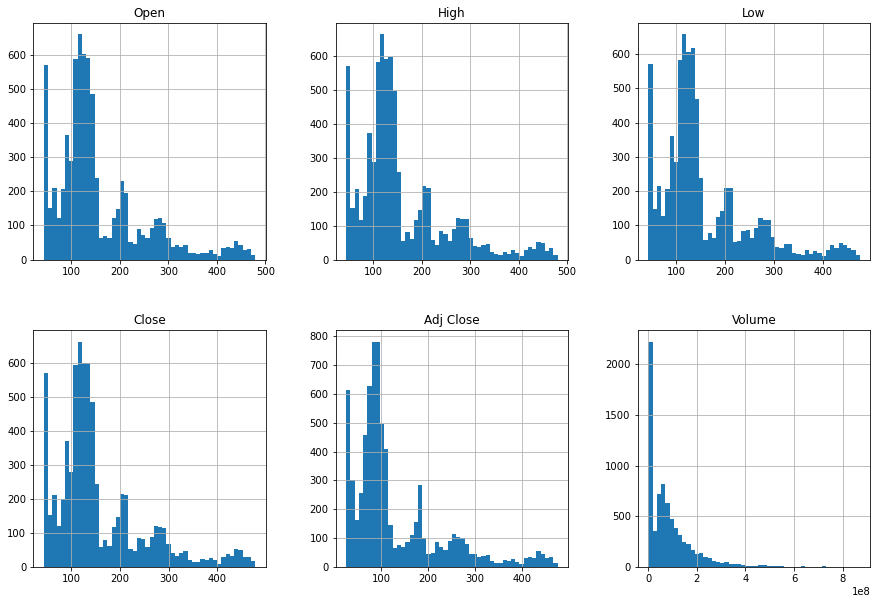

In [4]:
import matplotlib.pyplot as plt

scale = 5
data.hist(bins=50, figsize=(3*scale,2*scale), layout=(2,3))
plt.show()

## 2. Vanilla RNN

In [5]:
def ts_split(ts, feature_steps=10, target_steps=1):
    ts = ts.flatten()
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [6]:
from sklearn.preprocessing import MinMaxScaler

def ts_process(ts, train_start_date, train_end_date, valid_start_date, valid_end_date,
               test_start_date, test_end_date, window=10, ahead=1):
    train = ts[train_start_date:train_end_date]
    valid = ts[valid_start_date:valid_end_date]
    test = ts[test_start_date:test_end_date]
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train.values.reshape(-1,1))
    X_train, y_train = ts_split(train, feature_steps=window, target_steps=ahead)
    valid = scaler.transform(valid.values.reshape(-1,1))
    X_valid, y_valid = ts_split(valid, feature_steps=window, target_steps=ahead)
    test = scaler.transform(test.values.reshape(-1,1))
    X_test, y_test = ts_split(test, feature_steps=window, target_steps=ahead)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [7]:
train_start_date = '2010-01-01'
train_end_date = '2017-12-31'
valid_start_date = '2018-01-01'
valid_end_date = '2018-12-31'
test_start_date = '2019-01-01'
test_end_date = '2019-12-31'
window = 10
ahead = 1

open = data['Open']
high = data['High']
low = data['Low']
close = data['Close']
volume = data['Volume']

X_open_train, y_open_train, X_open_valid, y_open_valid, X_open_test, y_open_test \
    = ts_process(open, train_start_date, train_end_date, valid_start_date, valid_end_date,
                 test_start_date, test_end_date, window, ahead)
X_high_train, y_high_train, X_high_valid, y_high_valid, X_high_test, y_high_test \
    = ts_process(high, train_start_date, train_end_date, valid_start_date, valid_end_date,
                 test_start_date, test_end_date, window, ahead)
X_low_train, y_low_train, X_low_valid, y_low_valid, X_low_test, y_low_test \
    = ts_process(low, train_start_date, train_end_date, valid_start_date, valid_end_date,
                 test_start_date, test_end_date, window, ahead)
X_close_train, y_close_train, X_close_valid, y_close_valid, X_close_test, y_close_test \
    = ts_process(close, train_start_date, train_end_date, valid_start_date, valid_end_date,
                 test_start_date, test_end_date, window, ahead)
X_volume_train, y_volume_train, X_volume_valid, y_volume_valid, X_volume_test, y_volume_test \
    = ts_process(volume, train_start_date, train_end_date, valid_start_date, valid_end_date,
                 test_start_date, test_end_date, window, ahead)

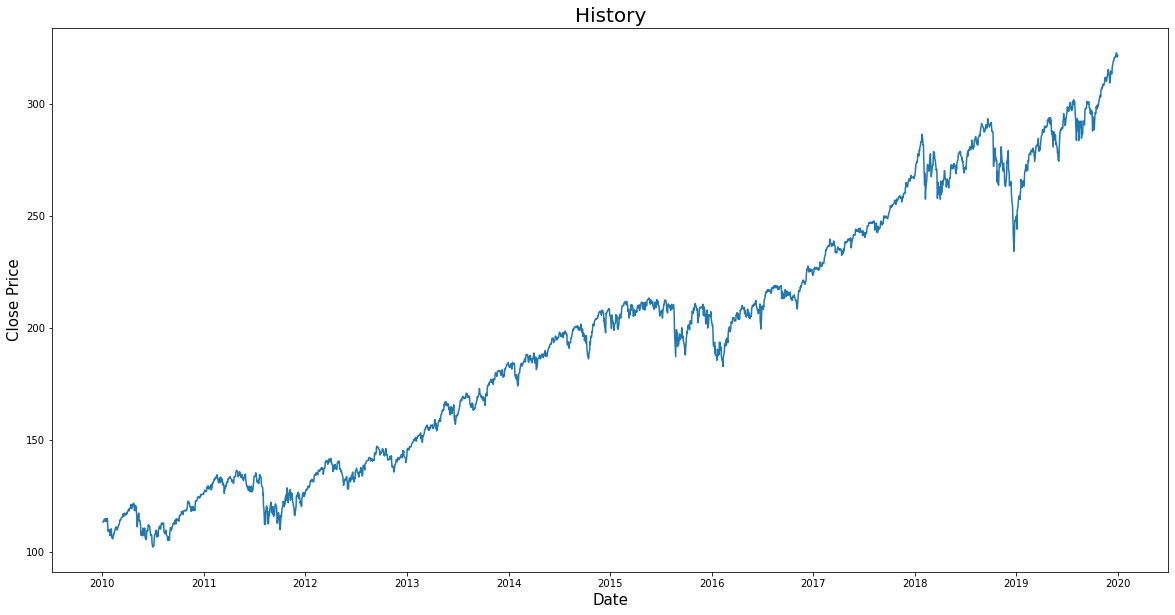

In [8]:
history = close[train_start_date:test_end_date]

plt.figure(figsize=(20,10))
plt.title('History', fontsize=20)
plt.plot(history)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.show()

In [10]:
X_train = np.dstack([X_open_train, X_high_train, X_low_train, X_close_train, X_volume_train])
y_train = y_close_train
X_valid = np.dstack([X_open_valid, X_high_valid, X_low_valid, X_close_valid, X_volume_valid])
y_valid = y_close_valid
X_test = np.dstack([X_open_test, X_high_test, X_low_test, X_close_test, X_volume_test])
y_test = y_close_test

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
import random as python_random

def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [18]:
%%time
# Hyperparamter combinations
n_hidden_list = [2, 3, 4, 5]
n_neuron_list = [20, 30, 40, 50, 60]
drop_rate_list = [0.1, 0.2, 0.3, 0.4, 0.5]
re_drop_rate_list = [0.1, 0.2, 0.3, 0.4, 0.5]
rmse_list = []

# Gridsearch
for n_hidden in n_hidden_list:
    for n_neuron in n_neuron_list:
        for drop_rate in drop_rate_list:
            for re_drop_rate in re_drop_rate_list:
                reset_session()
                model = keras.models.Sequential()
                model.add(keras.layers.SimpleRNN(n_neuron, return_sequences=True,
                                                 dropout=drop_rate, recurrent_dropout=re_drop_rate,
                                                 input_shape=[X_train.shape[1], X_train.shape[2]]))
                for layer in range(n_hidden-2):
                    model.add(keras.layers.SimpleRNN(n_neuron, return_sequences=True,
                                                     dropout=drop_rate, recurrent_dropout=re_drop_rate))
                model.add(keras.layers.SimpleRNN(n_neuron, return_sequences=False,
                                                 dropout=drop_rate, recurrent_dropout=re_drop_rate))
                model.add(keras.layers.Dense(1))
                model.compile(loss="mse", optimizer="nadam")
                early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                  patience=10,
                                                                  restore_best_weights=True)
                model.fit(X_train, y_train, epochs=200,
                          validation_data=(X_valid, y_valid),
                          callbacks=early_stopping_cb, verbose=0)
                rmse_list.append(np.sqrt(model.evaluate(X_valid, y_valid, verbose=0)))

rmse_list = np.array(rmse_list)

CPU times: total: 2h 36min 36s
Wall time: 1h 7min 54s


In [21]:
# Best Hyperparamter
idx = 0
for n_hidden in n_hidden_list:
    for n_neuron in n_neuron_list:
        for drop_rate in drop_rate_list:
            for re_drop_rate in re_drop_rate_list:
                if idx == np.argmin(rmse_list):
                    print(["(n_hidden, n_neuron, drop_rate, re_drop_rate]):",
                           [n_hidden, n_neuron, drop_rate, re_drop_rate]])
                    print(rmse_list[idx])
                idx += 1

['(n_hidden, n_neuron, drop_rate, re_drop_rate]):', [2, 60, 0.1, 0.1]]
0.027098393627767565


In [24]:
# Best model
reset_session()
best_model = keras.models.Sequential()
best_model.add(keras.layers.SimpleRNN(60, return_sequences=True,
                                      dropout=0.1, recurrent_dropout=0.1,
                                      input_shape=[X_train.shape[1], X_train.shape[2]]))
best_model.add(keras.layers.SimpleRNN(60, return_sequences=False,
                                      dropout=0.1, recurrent_dropout=0.1))
best_model.add(keras.layers.Dense(1))

best_model.compile(loss="mse", optimizer="nadam")
checkpoint_cb = keras.callbacks.ModelCheckpoint("VanillaRNN.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)

run = best_model.fit(X_train, y_train, epochs=200,
                     validation_data=(X_valid, y_valid),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200
63/63 [==============================] - 2s 7ms/step - loss: 0.1247 - val_loss: 0.0026
Epoch 2/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0361 - val_loss: 0.0125
Epoch 3/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0218 - val_loss: 0.0094
Epoch 4/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0149 - val_loss: 0.0035
Epoch 5/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0052
Epoch 6/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0017
Epoch 7/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0010
Epoch 8/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0018
Epoch 9/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 9.0435e-04
Epoch 10/200
63/63 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0011
Epoch

In [25]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 60)            3960      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60)                7260      
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 11,281
Trainable params: 11,281
Non-trainable params: 0
_________________________________________________________________


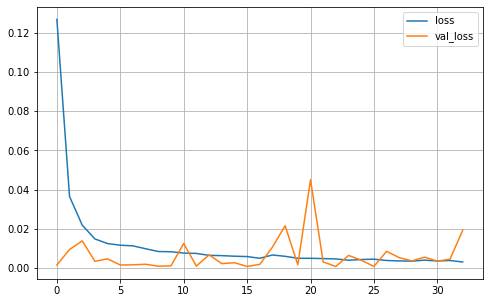

In [13]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(data['Close'][train_start_date:train_end_date].values.reshape(-1,1))
y_test_unscaled = scaler.inverse_transform(y_test)

y_pred = best_model.predict(X_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)
rmse_test = np.sqrt(mean_squared_error(y_pred_unscaled, y_test_unscaled))
rmse_test

9.210287222765688

In [18]:
from sklearn.metrics import accuracy_score

movement_test = X_close_test[:,-1] < y_test.ravel()
movement_pred = X_close_test[:,-1] < y_pred.ravel()

move_accuracy = accuracy_score(movement_test, movement_pred)
move_accuracy

0.45041322314049587

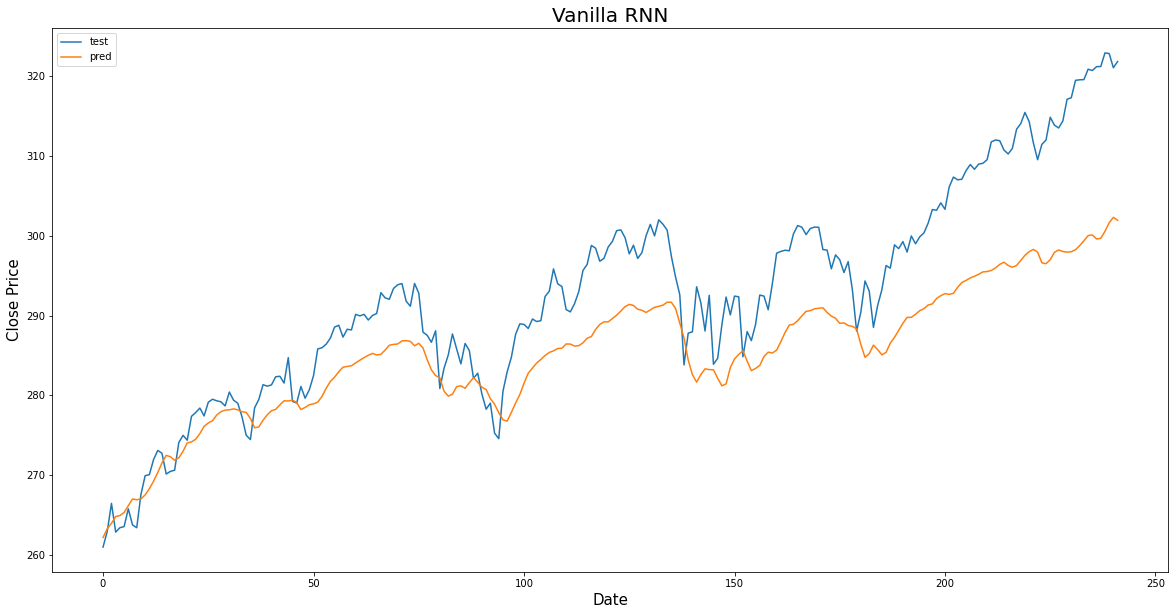

In [21]:
plt.figure(figsize=(20,10))
plt.title('Vanilla RNN', fontsize=20)
plt.plot(y_test_unscaled, label='test')
plt.plot(y_pred_unscaled, label='pred')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend()
plt.show()

## 3. LSTM

In [35]:
%%time
# Hyperparamter combinations
n_hidden_list = [2, 3, 4, 5]
n_neuron_list = [20, 30, 40, 50, 60]
drop_rate_list = [0.1, 0.2, 0.3, 0.4, 0.5]
re_drop_rate_list = [0.1, 0.2, 0.3, 0.4, 0.5]
rmse_list = []

# Gridsearch
for n_hidden in n_hidden_list:
    for n_neuron in n_neuron_list:
        for drop_rate in drop_rate_list:
            for re_drop_rate in re_drop_rate_list:
                reset_session()
                model = keras.models.Sequential()
                model.add(keras.layers.LSTM(n_neuron, return_sequences=True,
                                            dropout=drop_rate, recurrent_dropout=re_drop_rate,
                                            input_shape=[X_train.shape[1], X_train.shape[2]]))
                for layer in range(n_hidden-2):
                    model.add(keras.layers.LSTM(n_neuron, return_sequences=True,
                                                dropout=drop_rate, recurrent_dropout=re_drop_rate))
                model.add(keras.layers.LSTM(n_neuron, return_sequences=False,
                                            dropout=drop_rate, recurrent_dropout=re_drop_rate))
                model.add(keras.layers.Dense(1))
                model.compile(loss="mse", optimizer="nadam")
                early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                  patience=10,
                                                                  restore_best_weights=True)
                model.fit(X_train, y_train, epochs=200,
                          validation_data=(X_valid, y_valid),
                          callbacks=early_stopping_cb, verbose=0)
                rmse_list.append(np.sqrt(model.evaluate(X_valid, y_valid, verbose=0)))

rmse_list = np.array(rmse_list)

CPU times: total: 13h 52min 28s
Wall time: 3h 16min 29s


In [36]:
# Best Hyperparamter
idx = 0
for n_hidden in n_hidden_list:
    for n_neuron in n_neuron_list:
        for drop_rate in drop_rate_list:
            for re_drop_rate in re_drop_rate_list:
                if idx == np.argmin(rmse_list):
                    print(["(n_hidden, n_neuron, drop_rate, re_drop_rate]):",
                           [n_hidden, n_neuron, drop_rate, re_drop_rate]])
                    print(rmse_list[idx])
                idx += 1

['(n_hidden, n_neuron, drop_rate, re_drop_rate]):', [2, 40, 0.1, 0.4]]
0.02824398970228934


In [26]:
# Best model
reset_session()
best_model = keras.models.Sequential()
best_model.add(keras.layers.LSTM(40, return_sequences=True,
                                 dropout=0.1, recurrent_dropout=0.4,
                                 input_shape=[X_train.shape[1], X_train.shape[2]]))
best_model.add(keras.layers.LSTM(40, return_sequences=False,
                                 dropout=0.1, recurrent_dropout=0.4))
best_model.add(keras.layers.Dense(1))

best_model.compile(loss="mse", optimizer="nadam")
checkpoint_cb = keras.callbacks.ModelCheckpoint("LSTM.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)

run = best_model.fit(X_train, y_train, epochs=200,
                     validation_data=(X_valid, y_valid),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200
63/63 [==============================] - 4s 12ms/step - loss: 0.0274 - val_loss: 0.0023
Epoch 2/200
63/63 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/200
63/63 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 4/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/200
63/63 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/200
63/63 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 7/200
63/63 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0072
Epoch 11

In [27]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 40)            7360      
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,361
Trainable params: 20,361
Non-trainable params: 0
_________________________________________________________________


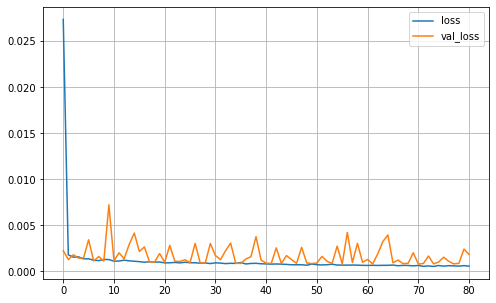

In [28]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [29]:
y_pred = best_model.predict(X_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)
rmse_test = np.sqrt(mean_squared_error(y_pred_unscaled, y_test_unscaled))
rmse_test

5.473322904769099

In [30]:
from sklearn.metrics import accuracy_score

movement_test = X_close_test[:,-1] < y_test.ravel()
movement_pred = X_close_test[:,-1] < y_pred.ravel()

move_accuracy = accuracy_score(movement_test, movement_pred)
move_accuracy

0.4462809917355372

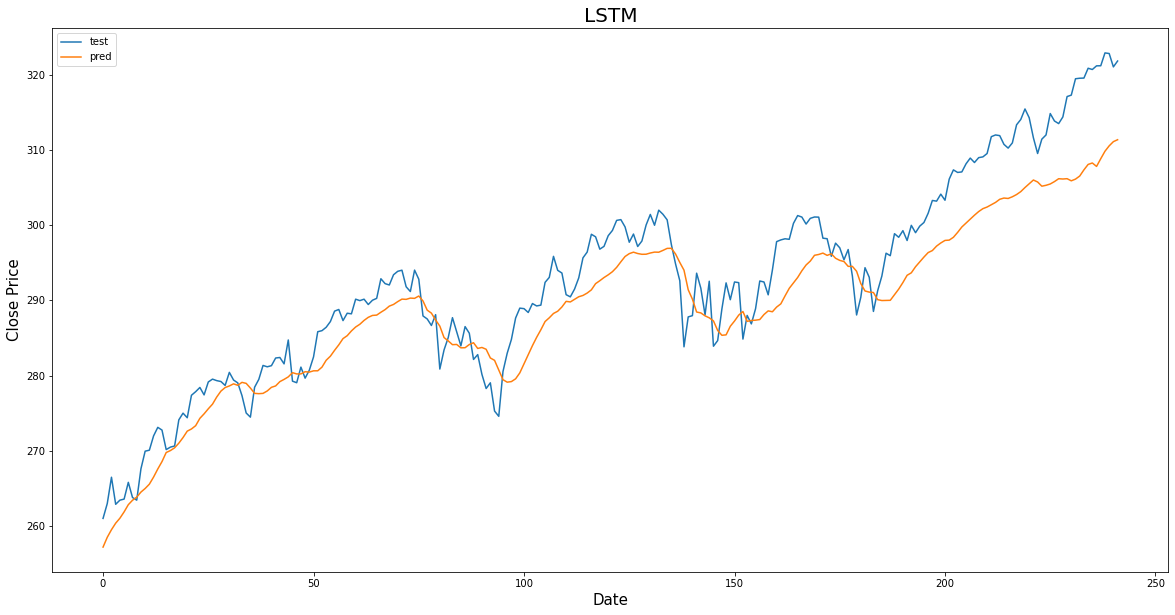

In [31]:
date = data[test_start_date:test_end_date].index

plt.figure(figsize=(20,10))
plt.title('LSTM', fontsize=20)
plt.plot(y_test_unscaled, label='test')
plt.plot(y_pred_unscaled, label='pred')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend()
plt.show()

## 3. Movement Forecast

In [227]:
import talib as ta

data = pd.read_csv('data/MSFT.csv', index_col=0)
data.index = pd.to_datetime(data.index)

data = data.drop('Adj Close', axis=1)

data['SMA10'] = ta.SMA(data['Close'], timeperiod=10)
data['SMA30'] = ta.SMA(data['Close'], timeperiod=30)
data['SMA200'] = ta.SMA(data['Close'], timeperiod=200)
data['EMA10'] = ta.EMA(data['Close'], timeperiod=10)
data['EMA30'] = ta.EMA(data['Close'], timeperiod=30)
data['EMA200'] = ta.EMA(data['Close'], timeperiod=200)
data['MOM10'] = ta.MOM(data['Close'], timeperiod=10)
data['MOM30'] = ta.MOM(data['Close'], timeperiod=30)
data['MOM200'] = ta.MOM(data['Close'], timeperiod=200)
data['RSI10'] = ta.RSI(data['Close'], timeperiod=10)
data['RSI30'] = ta.RSI(data['Close'], timeperiod=30)
data['RSI200'] = ta.RSI(data['Close'], timeperiod=200)
data['K10'], data['D10'] = ta.STOCH(data['High'], data['Low'], data['Close'], fastk_period=10)
data['K30'], data['D30'] = ta.STOCH(data['High'], data['Low'], data['Close'], fastk_period=30)
data['K200'], data['D200'] = ta.STOCH(data['High'], data['Low'], data['Close'], fastk_period=200)
data['Movement'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

data = data.dropna()
data.head()

,Open,High,Low,Close,Volume,SMA10,SMA30,SMA200,EMA10,EMA30,...,RSI10,RSI30,RSI200,K10,D10,K30,D30,K200,D200,Movement
Date,,,,,,,,,,,,,,,,,,,,,
1986-12-31,0.165799,0.170139,0.165799,0.167535,23356800,0.167795,0.166464,0.117947,0.167448,0.162828,...,52.869841,60.266069,58.197867,47.053463,60.861885,67.443636,71.190205,86.275299,87.862662,0
1987-01-02,0.167535,0.169271,0.164931,0.165799,12643200,0.168056,0.167303,0.118286,0.167148,0.163020,...,49.036520,58.951990,57.958527,43.350721,49.712477,68.993941,68.993941,86.928857,86.928857,1
1987-01-05,0.165799,0.177083,0.164931,0.175347,48499200,0.169141,0.168287,0.118685,0.168639,0.163815,...,64.684351,63.482389,58.892992,58.475433,49.626539,77.143534,71.193704,90.523423,87.909193,1
1987-01-06,0.175347,0.178819,0.174479,0.177951,40032000,0.170096,0.168982,0.119110,0.170332,0.164727,...,67.690500,64.585149,59.141916,72.104360,57.976838,85.112068,77.083181,94.121156,90.524479,1
1987-01-07,0.177951,0.187500,0.177951,0.187500,60998400,0.171832,0.169821,0.119596,0.173453,0.166196,...,76.010742,68.225165,60.033864,94.324405,74.968066,95.964189,86.073264,98.696057,94.446879,1


In [228]:
from sklearn.preprocessing import StandardScaler

X_train = data['2010-01-01':'2017-12-31'].iloc[:, 0:-1]
y_train = data['2010-01-01':'2017-12-31'].iloc[:, -1]
X_test = data['2018-01-01':'2019-12-31'].iloc[:, 0:-1]
y_test = data['2018-01-01':'2019-12-31'].iloc[:, -1]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [229]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grids = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 6],
    "gamma": [0, 0.1, 0.2, 0.5],
    "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2, 0.5],
    "min_child_weight":[1, 2, 4, 8, 16]
}

xgb = XGBClassifier(objective='binary:logistic', random_state=42)
grid_search = GridSearchCV(xgb, param_grids, cv=3,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

CPU times: total: 5h 1min 17s
Wall time: 21min 25s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [232]:
best_model = grid_search.best_estimator_
grid_search.best_params_

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 100}

In [233]:
y_pred = best_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.5606361829025845

In [ ]:
## MSFT 10-17 18-19
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=200, learning_rate=0.01, min_child_weight=4, max_depth=3)
xgb.fit(X_train, y_train)